# Выполнил Кирилл Сетдеков

In [3]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from statsmodels.stats.weightstats import *
import matplotlib.pyplot as plt
from statsmodels.stats.descriptivestats import sign_test

import statsmodels.formula.api as smf
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.preprocessing import PowerTransformer


import statsmodels.api as sm
import warnings
import matplotlib
import matplotlib.dates as mdates
from pandas.plotting import lag_plot
from random import shuffle


In [4]:
%matplotlib inline
# %matplotlib widget

#  Задание 1

1. Автокорреляционная функция и частная автокорреляционная функция.

    * Автокорреляционная функция - функция, которая для каждого значения лага выдает коэффициент корреляции между временным рядом и временным рядом с эти лагом.
    * Частная автокорреляционная функция - функция, которая для каждого лага k выдает автокорреляцию между исходным рядом $z_{t}$, очиценным от линейной связи со всеми предшествующими лагами от $z_{t+1}$ до $z_{t+k-1}$ и рядом  $z_{{t+k}}$. 

2. Какой временной ряд называется стационарным? Может ли временной ряд с трендом быть стационарным? А с циклом?

    * Стационарный ряд - такой ряд, у которого вероятностные характеристики не меняются во времени.

    * Если говорим про тренд - мы будем ожидать, что такой ряд интегрированный порядка 1, и сам не стационарный. Но ряд из растностей может быть стационарным, а может и не быть.

    * Если мы говорим про циклы, имеющие некий фиксированный период (сезонность), то такой ряд не стационарный, если длина цикла случайна, то такой ряд может быть стационарным.
  

3. Какую гипотезу проверяет тест Дики-Фуллера.

    * Тесть проверяет гипотезу о стационарности ряда и $H_0$ - ряд не стационарный, то есть когда мы отвергаем гипотезу, мы узнаем, что ряд стационарный.

4. Какой временной рядм можно описать хорошо с помощью модели ARMA?

    * Под эту модель подходят хорошо ряды со следующими свойствами:

        * Ряд стационарный.
        * Нет внешних переменных, которые влияют на значения ряда (сходу без модификации в эту модель не добавить регрессую от других рядов).
        * Есть зависимость от значений переменной в прошлом и от остатков на прошлых шагах.

5. На что нужно обращать внимание при анализе остатков модели

    * Проверять соответствие их распределения нормальному.
    * Тестировать их на стационарность.
    * Обращать внимание на наличие периодичности и/или гетероскедастичности.



# Задание 2
Шампунь, продажи за 3 года. Подобрать модель SARIMA и сделать прогноз на 3 месяца вперед.

In [5]:
shampoo = pd.read_csv('data/shampoo.csv')


In [6]:
shampoo["Month"] = pd.to_datetime('0'+shampoo.Month, format='%y-%m')
shampoo = shampoo.set_index("Month")
shampoo.head()

,Sales
Month,
2001-01-01,266.0
2001-02-01,145.9
2001-03-01,183.1
2001-04-01,119.3
2001-05-01,180.3


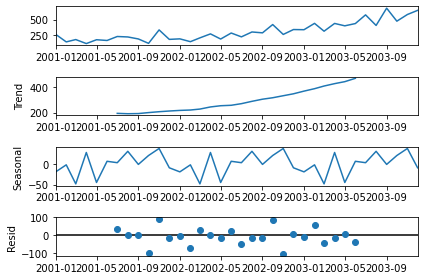

In [7]:
decompostition = sm.tsa.seasonal_decompose(shampoo, model= 'additive')
fig = decompostition.plot()


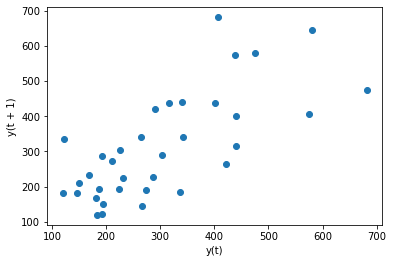

In [8]:
plt.figure()
lag_plot(shampoo)
plt.show()

Видим, что есть тренд, и сезонность, ожидание, что ряд не стационарный и что есть автокорреляция. Проверим:

In [9]:
from statsmodels.tsa.stattools import adfuller


def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [10]:
print("Критерий Дики-Фуллера для начального ряда: pvalue =",sm.tsa.stattools.adfuller(shampoo.Sales)[1])

Критерий Дики-Фуллера для начального ряда: pvalue = 1.0


In [11]:
adf_test(shampoo)

Results of Dickey-Fuller Test:
Test Statistic                  3.060142
p-value                         1.000000
#Lags Used                     10.000000
Number of Observations Used    25.000000
Critical Value (1%)            -3.723863
Critical Value (5%)            -2.986489
Critical Value (10%)           -2.632800
dtype: float64


Такой ряд не стационарный - перейдем к разностям:

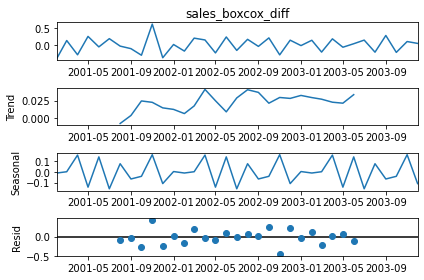

In [12]:
shampoo['sales_boxcox'], lmbd = stats.boxcox(shampoo['Sales'])
shampoo['sales_boxcox_diff'] = shampoo.sales_boxcox - shampoo.sales_boxcox.shift(1)
sm.tsa.seasonal_decompose(shampoo.sales_boxcox_diff[1:]).plot()
plt.show()

In [13]:
adf_test(shampoo.sales_boxcox_diff[1:])

Results of Dickey-Fuller Test:
Test Statistic                 -3.971330
p-value                         0.001568
#Lags Used                      9.000000
Number of Observations Used    25.000000
Critical Value (1%)            -3.723863
Critical Value (5%)            -2.986489
Critical Value (10%)           -2.632800
dtype: float64


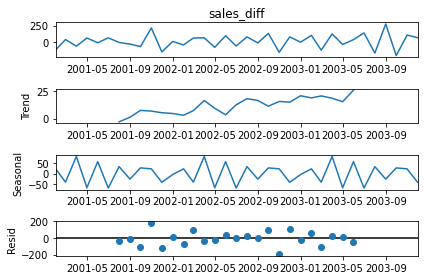

In [14]:
shampoo['sales_diff'] = shampoo.Sales - shampoo.Sales.shift(1)
sm.tsa.seasonal_decompose(shampoo.sales_diff[1:]).plot()
plt.show()

In [15]:
adf_test(shampoo.sales_diff[1:])

Results of Dickey-Fuller Test:
Test Statistic                -7.249074e+00
p-value                        1.799857e-10
#Lags Used                     1.000000e+00
Number of Observations Used    3.300000e+01
Critical Value (1%)           -3.646135e+00
Critical Value (5%)           -2.954127e+00
Critical Value (10%)          -2.615968e+00
dtype: float64


без преобразования Бокса-Кокса, мы получаем более низкое p-value для теста Дики-Фулера, поэтому возьмем только разницы, а чтобы брать дельты дополнительные, уже нет данных

посмотрим на автокорреляционные и частные автокорреляционные графики

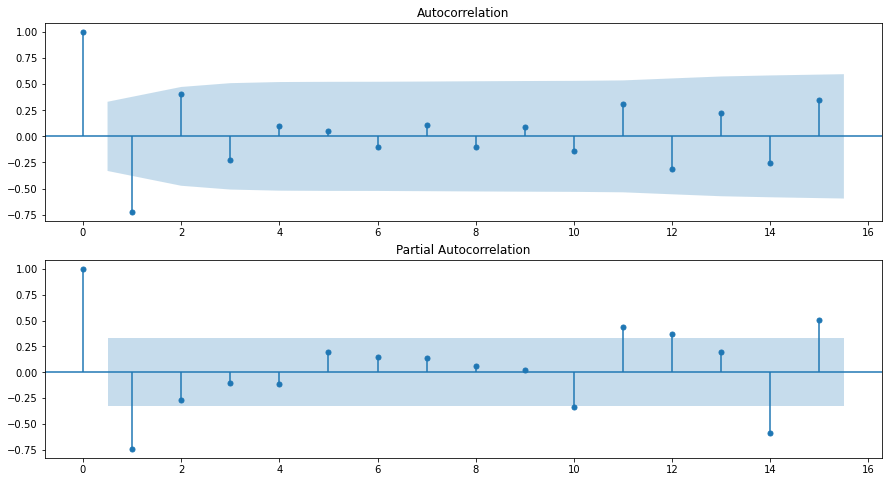

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows=2,figsize=(15,8)) 

sm.graphics.tsa.plot_acf(shampoo.sales_diff[1:].values.squeeze(), lags=15, ax=ax1)
sm.graphics.tsa.plot_pacf(shampoo.sales_diff[1:].values.squeeze(), lags=15, ax=ax2)

plt.show()

Согласно этим графикам, в качестве начальных значений необходимо взять: $Q=1$, $q=1$, $P=1$, $p=1$.

In [17]:
from itertools import product # произведения множеств

# создадим список из значений параметров для перебора моделей


d = 1
D = range(0, 2)
ps = range(0, 2)
qs = range(0, 2)
Ps = range(0, 2)
Qs = range(0, 2)
trend = ['n', 'c', 't', 'ct']

parameters = product(ps ,qs, Ps, Qs, D, trend)
parameters_list = list(parameters)

In [18]:
from tqdm.notebook import tqdm


In [19]:
results = [] # здесь будем хранить результаты
warnings.filterwarnings('ignore') # не для всех параметров модели будут обучаться; отключим предупреждения

for param in tqdm(parameters_list):
    #try-except нужен, чтобы обработать случаи, когда модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(shampoo.Sales, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], param[4], param[3], 12), trend=param[5]).fit(disp=-1)
    
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('Wrong parameters:', param)
        continue
    
    results.append([param, model.aic])
# преобразуем результаты в DataFrame и добавим названия столбцов

result_table = pd.DataFrame(results)
result_table.columns = ['Parameters', 'AIC']

  0%|          | 0/128 [00:00<?, ?it/s]

In [20]:
result_table.sort_values(by = 'AIC', ascending=True).head()

,Parameters,AIC
117,"(1, 1, 1, 0, 1, c)",275.535467
109,"(1, 1, 0, 1, 1, c)",275.935526
118,"(1, 1, 1, 0, 1, t)",276.586929
119,"(1, 1, 1, 0, 1, ct)",277.122648
125,"(1, 1, 1, 1, 1, c)",277.258428


Лучшей моделью получилась SARIMA (1,1,1)x(1,0,1).

In [21]:
best_model=sm.tsa.statespace.SARIMAX(shampoo.Sales, order=(1,1,1), trend='c', seasonal_order=(1,1,0,12)).fit(disp=-1)
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                   36
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                -132.768
Date:                             Sun, 08 Aug 2021   AIC                            275.535
Time:                                     11:08:21   BIC                            281.213
Sample:                                 01-01-2001   HQIC                           276.963
                                      - 12-01-2003                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     27.5420      4.660      5.910      0.000      18.408      36.676
ar.L1         -0.6273      

Посмотрим на остатки

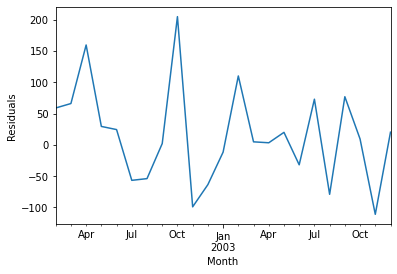

In [22]:
best_model.resid[13:].plot()
plt.ylabel('Residuals')
plt.show()

**Несмещенность.** Проверим несмещенность с помощью критерия знаков (самый универсальный критерий).

In [23]:
from statsmodels.stats.descriptivestats import sign_test
print("Критерий знаков для остатков: pvalue =",sign_test(best_model.resid[13:])[1])

Критерий знаков для остатков: pvalue = 0.21003961563110343


**Стационарность.** Проверим стационарность с помщью критерия Дики-Фуллера.

In [24]:
print("Критерий Дики-Фуллера для остатков: pvalue =",sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Критерий Дики-Фуллера для остатков: pvalue = 0.0006101274420046526


**Неавтокоррелированность.** Чтобы определить независимость остаткок, посмотрим на график автокорреляционной функции.

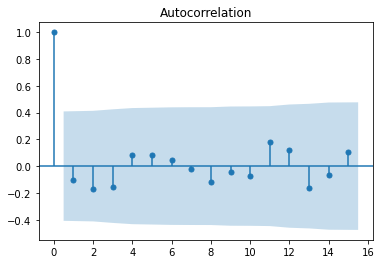

In [25]:
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=15)
plt.show()

Еще и по Jarque-Bera не отвергается гипотеза о нормальности

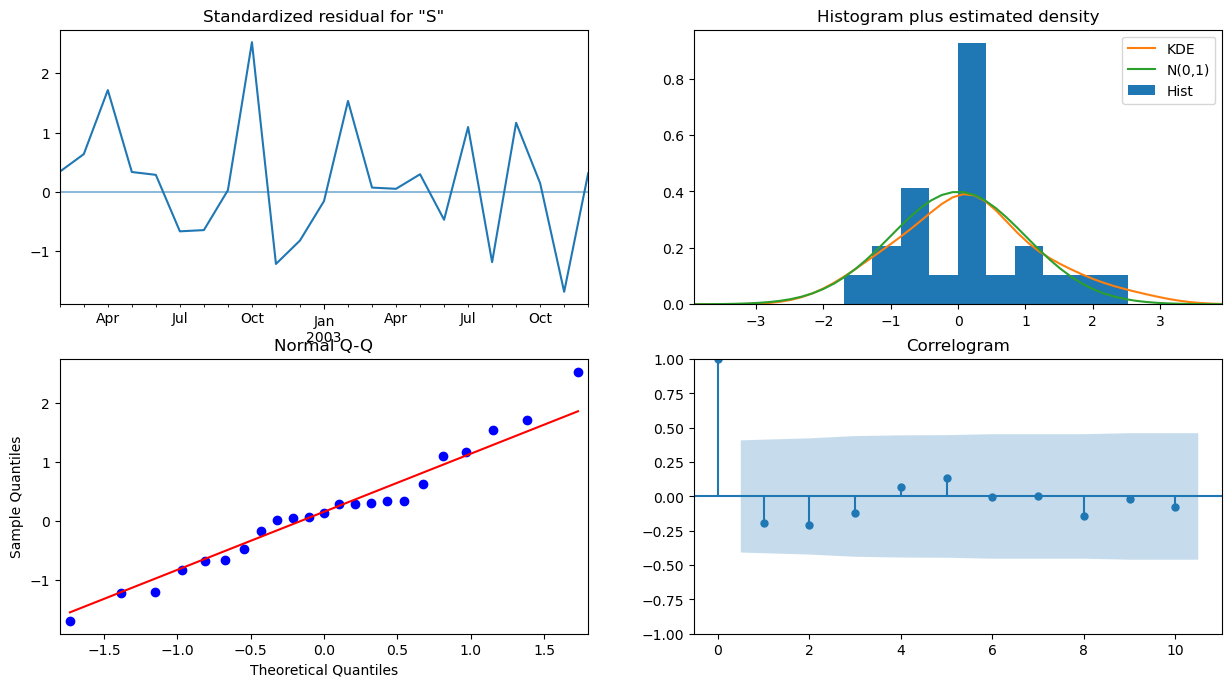

In [44]:
fig = plt.figure(figsize=(15,8), dpi= 100) 


best_model.plot_diagnostics(fig = fig)
fig.show()



In [27]:
shampoo['model'] = best_model.fittedvalues

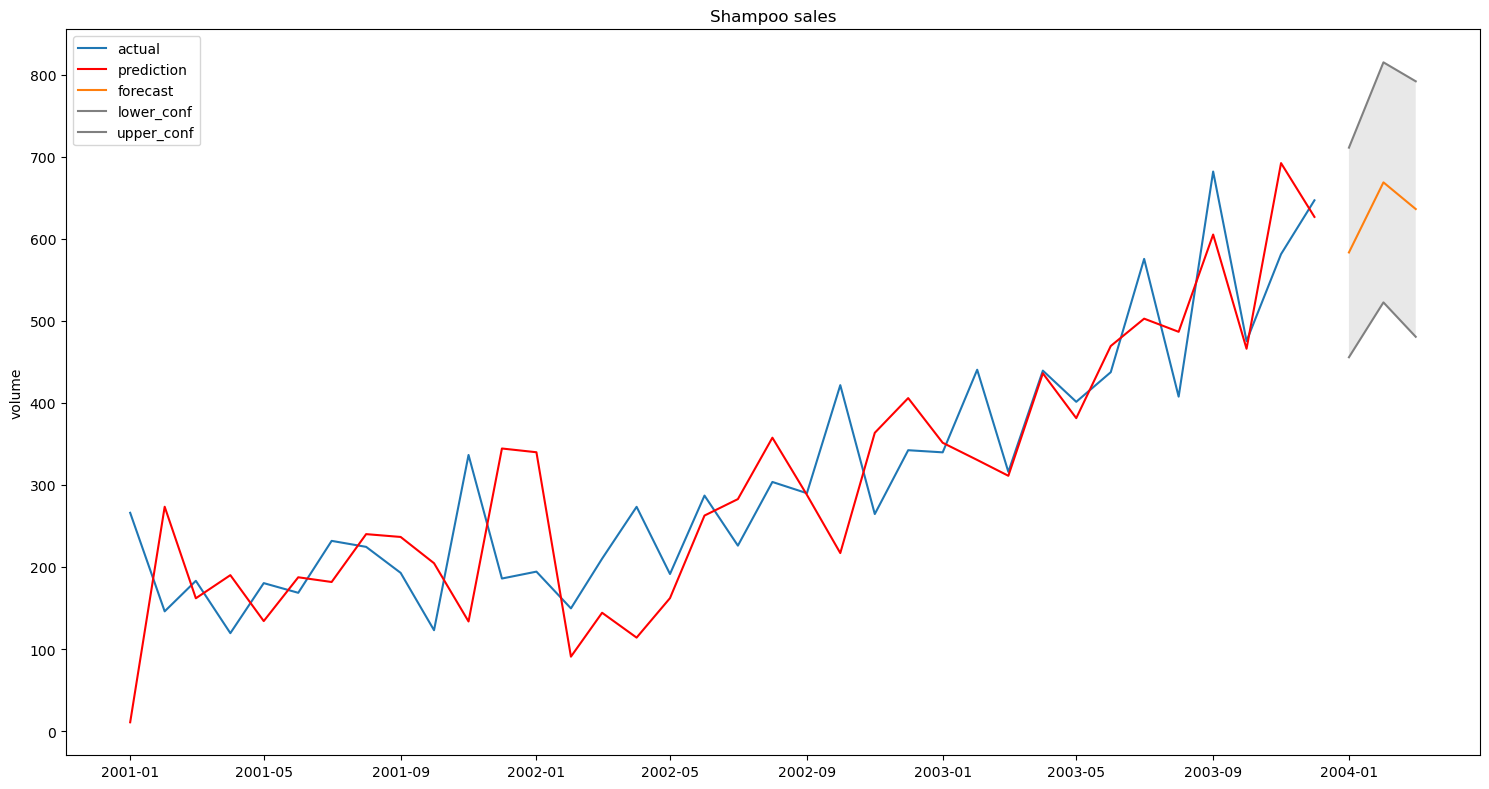

In [45]:
fig, ax = plt.subplots(figsize=(15,8), dpi= 100)
ax.plot(shampoo.Sales, label='actual')
ax.plot(shampoo.model, color='r', label='prediction')
ax.plot(best_model.get_forecast(3).predicted_mean, label='forecast')
ax.plot(best_model.get_forecast(3).conf_int()['lower Sales'], label='lower_conf', color = 'gray')
ax.plot(best_model.get_forecast(3).conf_int()['upper Sales'], label='upper_conf', color = 'gray')
ax.fill_between(best_model.get_forecast(3).predicted_mean.index, 
                best_model.get_forecast(3).conf_int()['lower Sales'], 
                best_model.get_forecast(3).conf_int()['upper Sales'], facecolor='lightgray', alpha=0.5)
ax.legend()

ax.set_ylabel('volume')
ax.set_title('Shampoo sales')
fig.tight_layout()
plt.show()


Мы получили прогноз продаж шампуня, сравнили его с историей и построили прогноз в будущее с доверительным интервалом

# Задание 3
Аналогично про новорожденных девочек


In [78]:
girls = pd.read_csv('data/female-births.csv') 
girls['Date'] = pd.to_datetime(girls['Date'])
girls = girls.set_index("Date")
girls.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


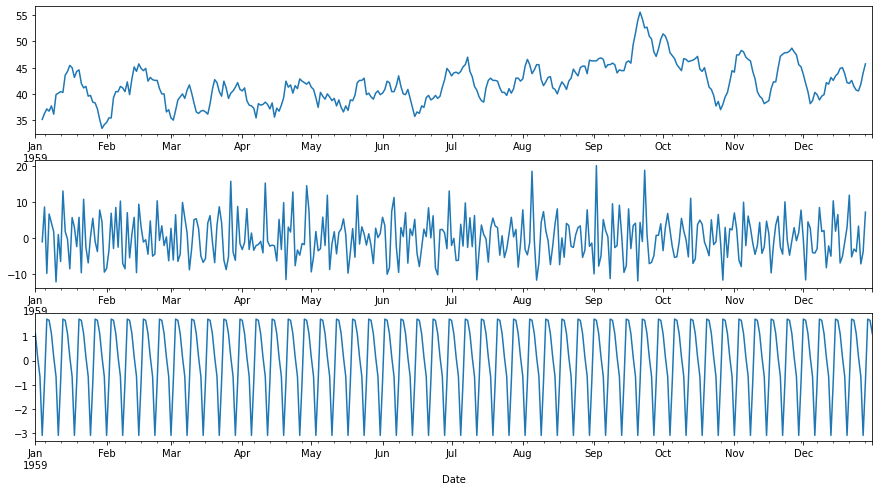

In [79]:

decompostition = sm.tsa.seasonal_decompose(girls, model= 'additive')


fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
decompostition.trend.plot(ax=ax1)
decompostition.resid.plot(ax=ax2)
decompostition.seasonal.plot(ax=ax3)
fig.show()

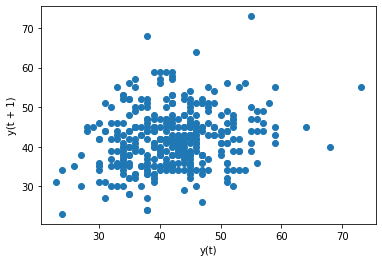

In [80]:
plt.figure()
lag_plot(girls)
plt.show()

In [81]:
adf_test(girls)

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


Есть небольшая зависимость значения от вчерашнего значения, но сам исходный ряд уже является стационарным

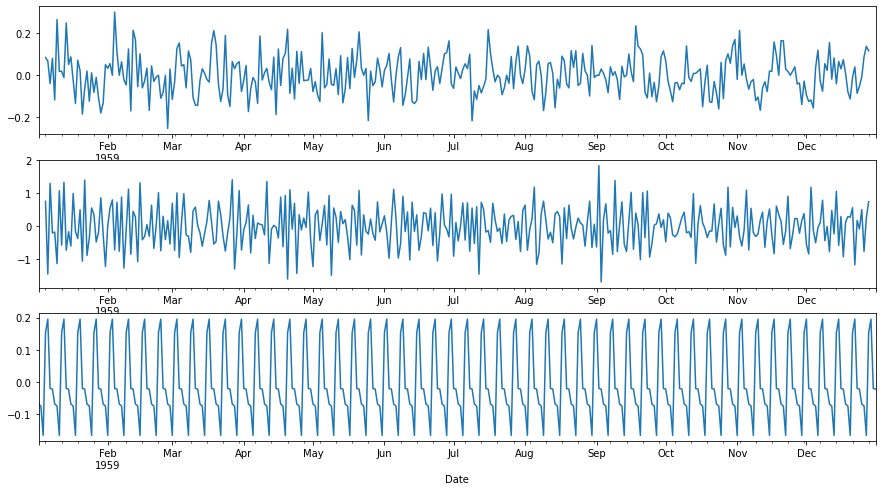

In [82]:
girls['births_boxcox'], lmbd = stats.boxcox(girls['Births'])
girls['births_boxcox_diff'] = girls.births_boxcox - girls.births_boxcox.shift(1)
girls_boxcos = sm.tsa.seasonal_decompose(girls.births_boxcox_diff[1:])


fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
girls_boxcos.trend.plot(ax=ax1)
girls_boxcos.resid.plot(ax=ax2)
girls_boxcos.seasonal.plot(ax=ax3)
fig.show()

In [83]:
adf_test(girls.births_boxcox_diff[1:])

Results of Dickey-Fuller Test:
Test Statistic                -1.285895e+01
p-value                        5.159404e-24
#Lags Used                     6.000000e+00
Number of Observations Used    3.570000e+02
Critical Value (1%)           -3.448801e+00
Critical Value (5%)           -2.869670e+00
Critical Value (10%)          -2.571101e+00
dtype: float64


В таком варианте мы полностью избавились от переодичности (сделали преобразования данных Бокса-Кокса и перешли к разинцам)

Посмотрим на графики автокорреляции и частной автокорреляции

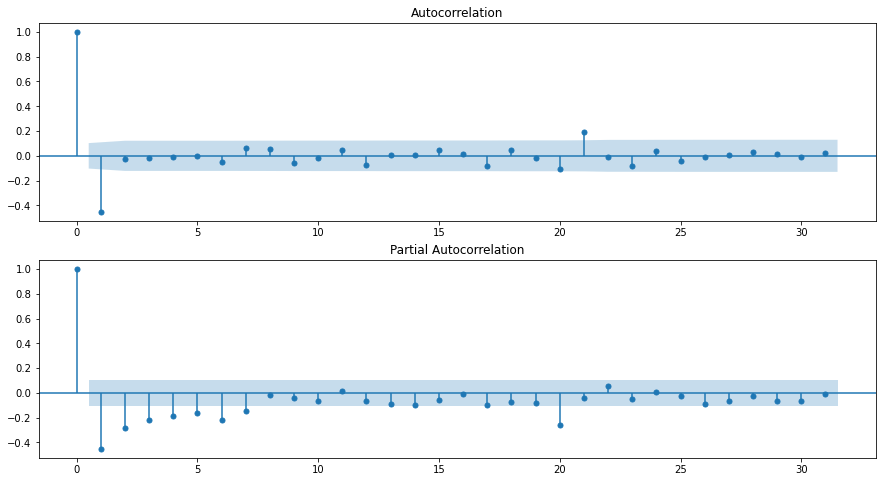

In [84]:
fig, (ax1, ax2) = plt.subplots(nrows=2,figsize=(15,8)) 

sm.graphics.tsa.plot_acf(girls.births_boxcox_diff[1:].values.squeeze(), lags=31, ax=ax1)
sm.graphics.tsa.plot_pacf(girls.births_boxcox_diff[1:].values.squeeze(), lags=31, ax=ax2)

plt.show()

Согласно этим графикам, в качестве начальных значений необходимо взять: $Q=3$, $q=7$, $P=1$, $p=1$.

In [85]:
# создадим список из значений параметров для перебора моделей
d = 1
D = 1
ps = range(0, 2)
qs = range(0, 8)
Ps = range(0, 2)
Qs = range(0, 4)
trend = ['n', 'c', 't', 'ct']

parameters = product(ps ,qs, Ps, Qs, trend)
parameters_list = list(parameters)

In [60]:
results2 = [] # здесь будем хранить результаты
warnings.filterwarnings('ignore') # не для всех параметров модели будут обучаться; отключим предупреждения

for param in tqdm(parameters_list):
    #try-except нужен, чтобы обработать случаи, когда модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(girls.births_boxcox, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 7), trend=param[4]).fit(disp=-1)
    
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('Wrong parameters:', param)
        continue
    
    results2.append([param, model.aic])
# преобразуем результаты в DataFrame и добавим названия столбцов

result_table2 = pd.DataFrame(results2)
result_table2.columns = ['Parameters', 'AIC']

  0%|          | 0/512 [00:00<?, ?it/s]

Wrong parameters: (0, 7, 0, 1, 'n')
Wrong parameters: (0, 7, 0, 1, 'c')
Wrong parameters: (0, 7, 0, 1, 't')
Wrong parameters: (0, 7, 0, 1, 'ct')
Wrong parameters: (0, 7, 0, 2, 'n')
Wrong parameters: (0, 7, 0, 2, 'c')
Wrong parameters: (0, 7, 0, 2, 't')
Wrong parameters: (0, 7, 0, 2, 'ct')
Wrong parameters: (0, 7, 0, 3, 'n')
Wrong parameters: (0, 7, 0, 3, 'c')
Wrong parameters: (0, 7, 0, 3, 't')
Wrong parameters: (0, 7, 0, 3, 'ct')
Wrong parameters: (0, 7, 1, 1, 'n')
Wrong parameters: (0, 7, 1, 1, 'c')
Wrong parameters: (0, 7, 1, 1, 't')
Wrong parameters: (0, 7, 1, 1, 'ct')
Wrong parameters: (0, 7, 1, 2, 'n')
Wrong parameters: (0, 7, 1, 2, 'c')
Wrong parameters: (0, 7, 1, 2, 't')
Wrong parameters: (0, 7, 1, 2, 'ct')
Wrong parameters: (0, 7, 1, 3, 'n')
Wrong parameters: (0, 7, 1, 3, 'c')
Wrong parameters: (0, 7, 1, 3, 't')
Wrong parameters: (0, 7, 1, 3, 'ct')
Wrong parameters: (1, 7, 0, 1, 'n')
Wrong parameters: (1, 7, 0, 1, 'c')
Wrong parameters: (1, 7, 0, 1, 't')
Wrong parameters: (1, 

In [61]:
result_table2.sort_values(by = 'AIC', ascending=True).head()


,Parameters,AIC
288,"(1, 1, 1, 2, n)",528.948172
88,"(0, 2, 1, 2, n)",529.419793
120,"(0, 3, 1, 2, n)",530.288123
292,"(1, 1, 1, 3, n)",530.692364
268,"(1, 1, 0, 1, n)",530.776979


Лучшей моделью получилась SARIMA (1,1,1)x(1,1,2).

In [63]:
best_model2=sm.tsa.statespace.SARIMAX(girls.births_boxcox, order=(1,1,1), trend='n', seasonal_order=(1,1,2,7)).fit(disp=-1)
print(best_model2.summary())

                                       SARIMAX Results                                        
Dep. Variable:                          births_boxcox   No. Observations:                  365
Model:             SARIMAX(1, 1, 1)x(1, 1, [1, 2], 7)   Log Likelihood                -258.474
Date:                                Sun, 08 Aug 2021   AIC                            528.948
Time:                                        11:55:46   BIC                            552.215
Sample:                                    01-01-1959   HQIC                           538.202
                                         - 12-31-1959                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1181      0.062      1.898      0.058      -0.004       0.240
ma.

**Несмещенность.** Проверим несмещенность с помощью критерия знаков (самый универсальный критерий).


In [65]:
print("Критерий знаков для остатков: pvalue =",sign_test(best_model2.resid[15:])[1])


Критерий знаков для остатков: pvalue = 0.09737618645561434


**Стационарность.** Проверим стационарность с помщью критерия Дики-Фуллера.


In [66]:
print("Критерий Дики-Фуллера для остатков: pvalue =",sm.tsa.stattools.adfuller(best_model2.resid[15:])[1])


Критерий Дики-Фуллера для остатков: pvalue = 2.1694519560417842e-30


**Неавтокоррелированность.** Чтобы определить независимость остаткок, посмотрим на график автокорреляционной функции.


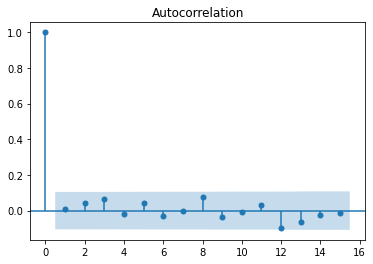

In [70]:
sm.graphics.tsa.plot_acf(best_model2.resid[15:].values.squeeze(), lags=15)
plt.show()


Еще и по Jarque-Bera не отвергается гипотеза о нормальности


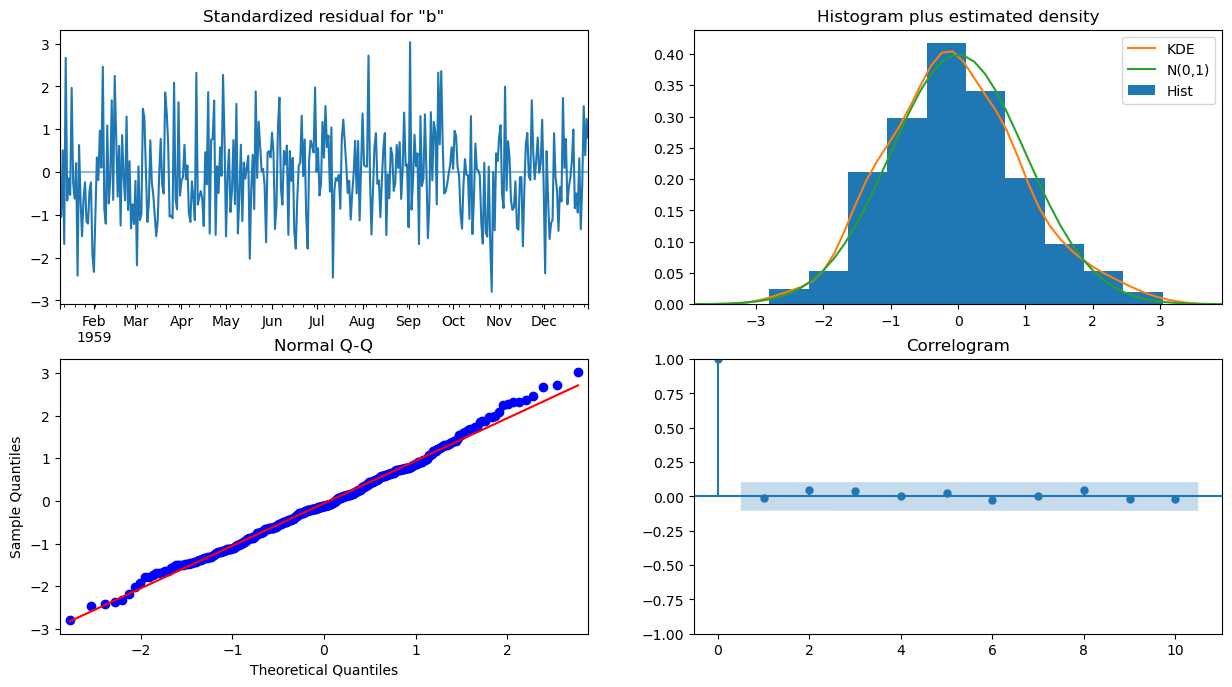

In [72]:
fig = plt.figure(figsize=(15,8), dpi= 100) 


best_model2.plot_diagnostics(fig = fig)
fig.show()



In [87]:
from scipy.special import inv_boxcox # обратное преобразование Бокса-Кокса 


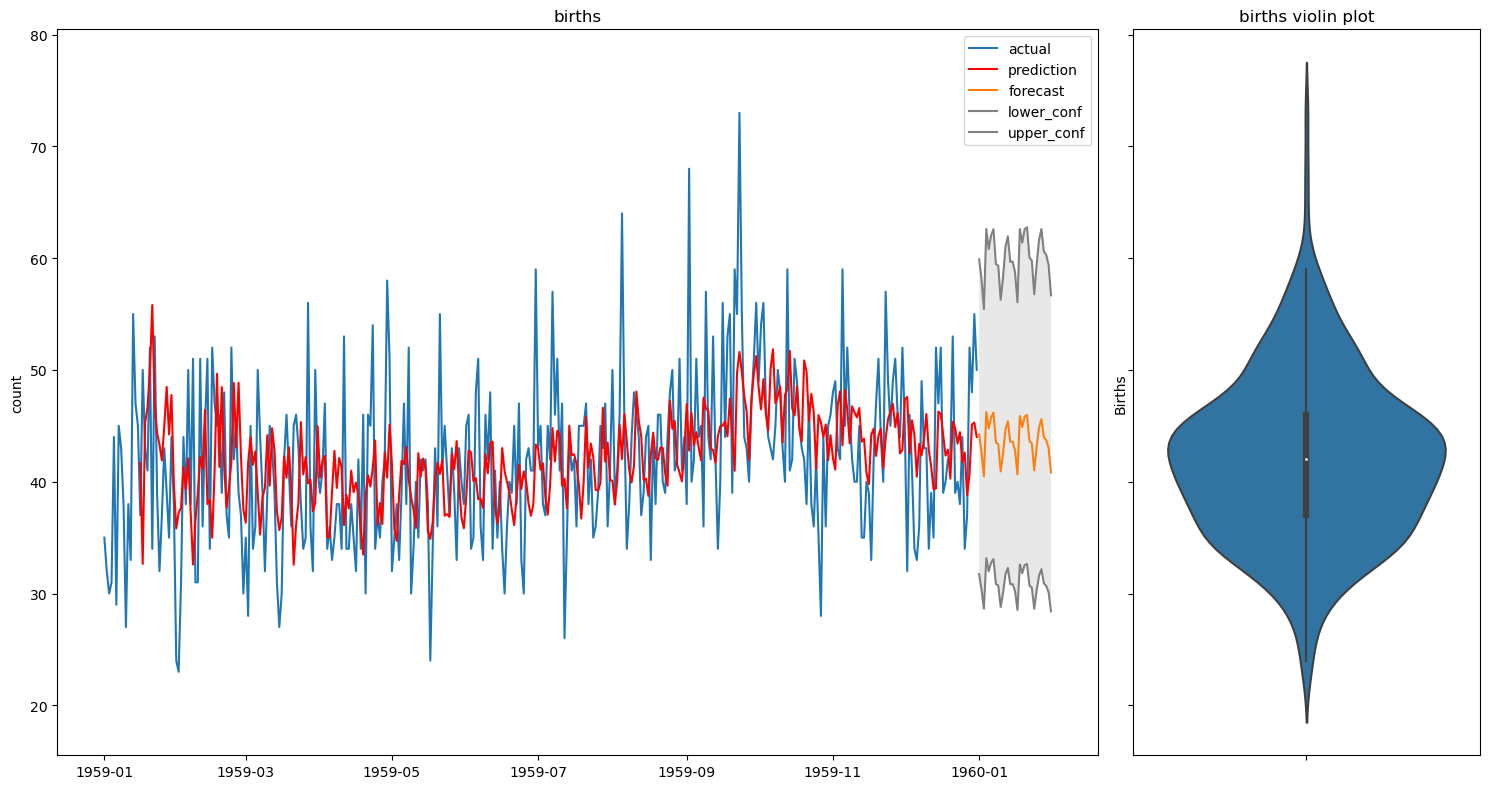

In [97]:
girls['model'] = inv_boxcox(best_model2.fittedvalues, lmbd)
fig, (ax, a2) = plt.subplots(1, 2,  sharey='row', gridspec_kw={'width_ratios': [3, 1]}, figsize=(15,8), dpi= 100)

ax.plot(girls.Births, label='actual')
ax.plot(girls.model[15:], color='r', label='prediction')
ax.plot(inv_boxcox(best_model2.get_forecast(31).predicted_mean, lmbd), label='forecast')
ax.plot(inv_boxcox(best_model2.get_forecast(31).conf_int()['lower births_boxcox'], lmbd), label='lower_conf', color = 'gray')
ax.plot(inv_boxcox(best_model2.get_forecast(31).conf_int()['upper births_boxcox'], lmbd), label='upper_conf', color = 'gray')
ax.fill_between(best_model2.get_forecast(31).predicted_mean.index, 
                inv_boxcox(best_model2.get_forecast(31).conf_int()['lower births_boxcox'], lmbd), 
                inv_boxcox(best_model2.get_forecast(31).conf_int()['upper births_boxcox'], lmbd), facecolor='lightgray', alpha=0.5)
ax.legend()

ax.set_ylabel('count')
ax.set_title('births')
a2 = sns.violinplot(y=girls.Births)
a2.set_title('births violin plot')

fig.tight_layout()
plt.show()

На выходе, наши предсказания выглядяд и по метрикам не плохи и улавливают недельную сезонность, но содержательно их доверительный интервал чуть лучше, чем использование межквартильного размаха с boxplot, а прогнох можно было бы делать и последним значением.

# Задание 4
Аналогично про лекартства от диабета, посмотреть прогноз на год вперед


In [99]:
drugs = pd.read_csv('data/anti-diabetic-drugs.csv')
drugs['date'] = pd.to_datetime(drugs['date'])
drugs = drugs.set_index("date")
drugs.head()

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


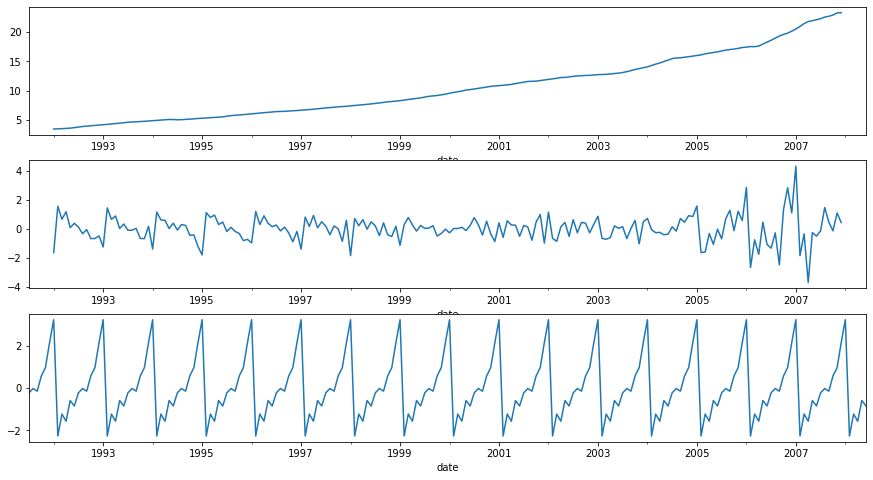

In [100]:
decompostition = sm.tsa.seasonal_decompose(drugs, model= 'additive')

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
decompostition.trend.plot(ax=ax1)
decompostition.resid.plot(ax=ax2)
decompostition.seasonal.plot(ax=ax3)
fig.show()

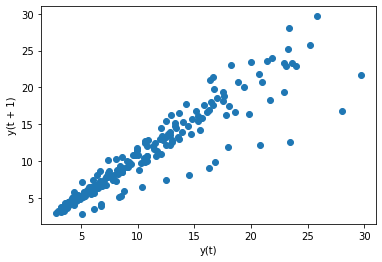

In [101]:
plt.figure()
lag_plot(drugs)
plt.show()

Про сезонность не очевидно? автокорреляция точно есть, но точно есть тренд и этот ряд не стационарный

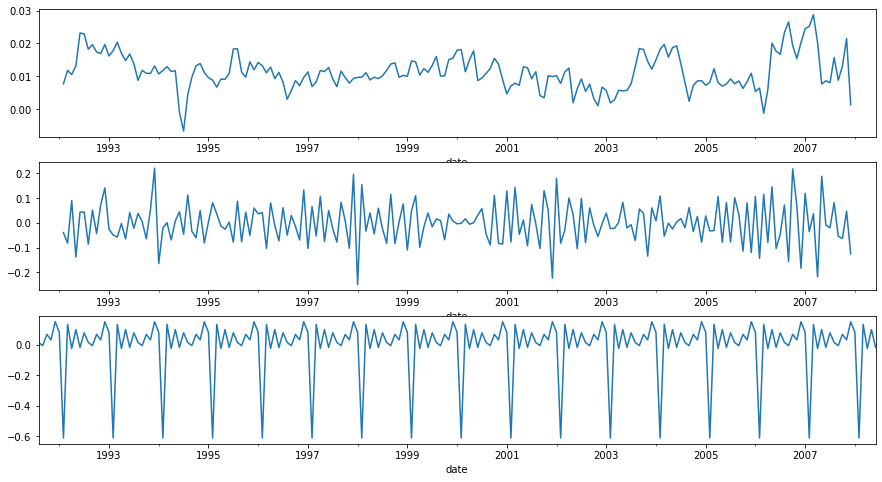

In [104]:
drugs['boxcox'], lmbd = stats.boxcox(drugs['value'])
drugs['boxcox_diff'] = drugs.boxcox - drugs.boxcox.shift(1)
drugs_boxcos = sm.tsa.seasonal_decompose(drugs.boxcox_diff[1:])


fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
drugs_boxcos.trend.plot(ax=ax1)
drugs_boxcos.resid.plot(ax=ax2)
drugs_boxcos.seasonal.plot(ax=ax3)
fig.show()

In [105]:
adf_test(drugs.boxcox_diff[1:])

Results of Dickey-Fuller Test:
Test Statistic                  -3.836085
p-value                          0.002559
#Lags Used                      15.000000
Number of Observations Used    187.000000
Critical Value (1%)             -3.465812
Critical Value (5%)             -2.877123
Critical Value (10%)            -2.575077
dtype: float64


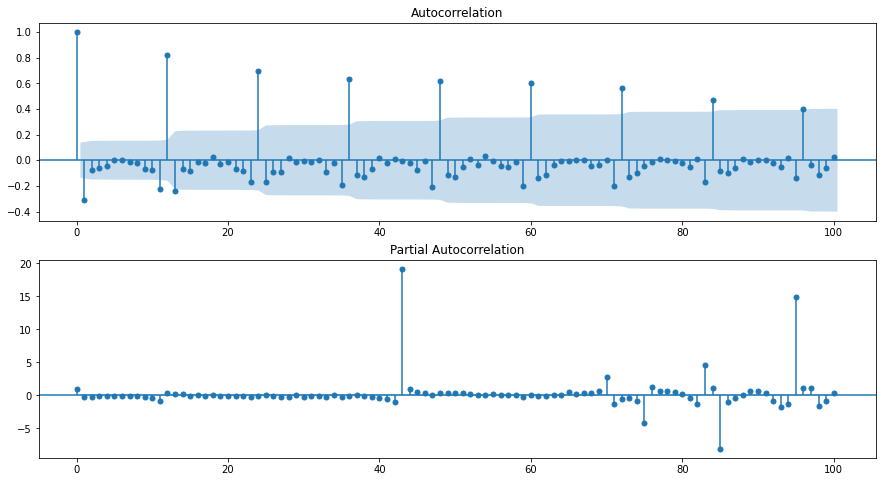

In [129]:
fig, (ax1, ax2) = plt.subplots(nrows=2,figsize=(15,8)) 

sm.graphics.tsa.plot_acf(drugs.boxcox_diff[1:].values.squeeze(), lags=100, ax=ax1)
sm.graphics.tsa.plot_pacf(drugs.boxcox_diff[1:].values.squeeze(), lags=100, ax=ax2)

plt.show()

In [127]:
96/12

8.0

$p$ - последний лаг, где PAC значимо

$q$ - последний лаг, где R значимо

$s= 12$ - сезонность

$P \times s$ - последний лаг, где PAC значимо

$Q \times s$ - последний лаг, где R значимо

Согласно этим графикам, в качестве начальных значений необходимо взять: $Q=8$, $q=1$, $P=8$, $p=14$.


In [159]:
# создадим список из значений параметров для перебора моделей
d = 1
D = 1
ps = range(0, 12)
qs = range(0, 2)
Ps = range(0, 9)
Qs = range(0, 9)
trend = ['n', 'c', 't', 'ct']

parameters = product(ps ,qs, Ps, Qs, trend)
parameters_list = list(parameters)


In [160]:
shuffle(parameters_list)

Переберем среди этих параметров случайно упорядоченных, часть пока хватит сил ждать. Суммарно ожидание перебора всех параметров 2 суток, остановимся вручную поэтому. Остановимся на лучшем, что сможем найти.

In [163]:
results3 = [] # здесь будем хранить результаты
warnings.filterwarnings('ignore') # не для всех параметров модели будут обучаться; отключим предупреждения

for param in tqdm(parameters_list):
    #try-except нужен, чтобы обработать случаи, когда модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(drugs.boxcox, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12), trend=param[4]).fit(disp=-1)
    
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('Wrong parameters:', param)
        continue
    
    results3.append([param, model.aic])
# преобразуем результаты в DataFrame и добавим названия столбцов

result_table3 = pd.DataFrame(results3)
result_table3.columns = ['Parameters', 'AIC']

  0%|          | 0/7776 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [165]:
result_table3 = pd.DataFrame(results3)
result_table3.columns = ['Parameters', 'AIC']

result_table3.sort_values(by = 'AIC', ascending=True).head()


,Parameters,AIC
153,"(4, 1, 1, 8, n)",-460.125936
179,"(7, 0, 4, 1, n)",-459.350104
175,"(5, 1, 0, 2, c)",-458.447990
173,"(7, 1, 4, 3, n)",-457.861615
12,"(6, 0, 6, 1, c)",-456.648173


In [166]:
best_model3=sm.tsa.statespace.SARIMAX(drugs.boxcox, order=(4,1,1), trend='n', seasonal_order=(1,1,8,12)).fit(disp=-1)
print(best_model3.summary())

                                                 SARIMAX Results                                                 
Dep. Variable:                                                    boxcox   No. Observations:                  204
Model:             SARIMAX(4, 1, 1)x(1, 1, [1, 2, 3, 4, 5, 6, 7, 8], 12)   Log Likelihood                 245.063
Date:                                                   Sun, 08 Aug 2021   AIC                           -460.126
Time:                                                           15:00:16   BIC                           -411.342
Sample:                                                       07-01-1991   HQIC                          -440.366
                                                            - 06-01-2008                                         
Covariance Type:                                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------

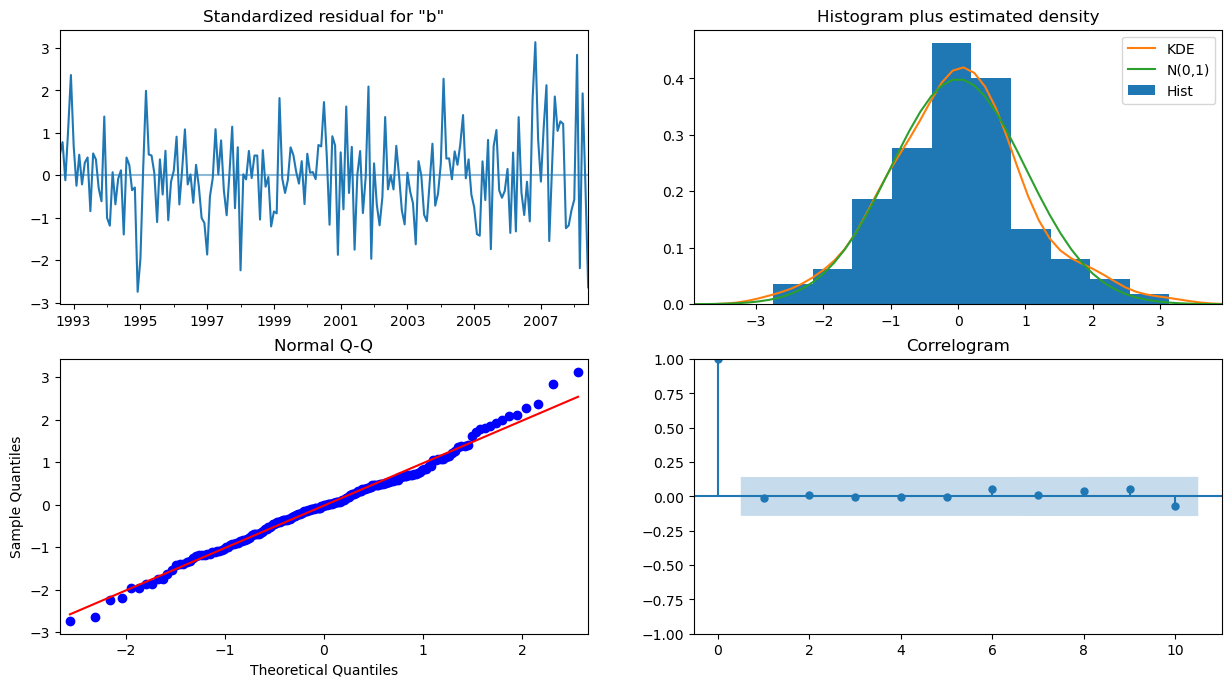

In [167]:
fig = plt.figure(figsize=(15,8), dpi= 100) 


best_model3.plot_diagnostics(fig = fig)
fig.show()



**Неавтокоррелированность.** Чтобы определить независимость остаткок, посмотрим на график автокорреляционной функции. Еще и по Jarque-Bera не отвергается гипотеза о нормальности

**Несмещенность.** Проверим несмещенность с помощью критерия знаков (самый универсальный критерий).


In [170]:
print("Критерий знаков для остатков: pvalue =",sign_test(best_model3.resid[13:])[1])


Критерий знаков для остатков: pvalue = 0.8849851393064638


**Стационарность.** Проверим стационарность с помщью критерия Дики-Фуллера.


In [171]:
print("Критерий Дики-Фуллера для остатков: pvalue =",sm.tsa.stattools.adfuller(best_model3.resid[13:])[1])

Критерий Дики-Фуллера для остатков: pvalue = 4.5856319009839295e-25


In [172]:
adf_test(best_model3.resid[13:])

Results of Dickey-Fuller Test:
Test Statistic                -1.340003e+01
p-value                        4.585632e-25
#Lags Used                     0.000000e+00
Number of Observations Used    1.900000e+02
Critical Value (1%)           -3.465244e+00
Critical Value (5%)           -2.876875e+00
Critical Value (10%)          -2.574945e+00
dtype: float64


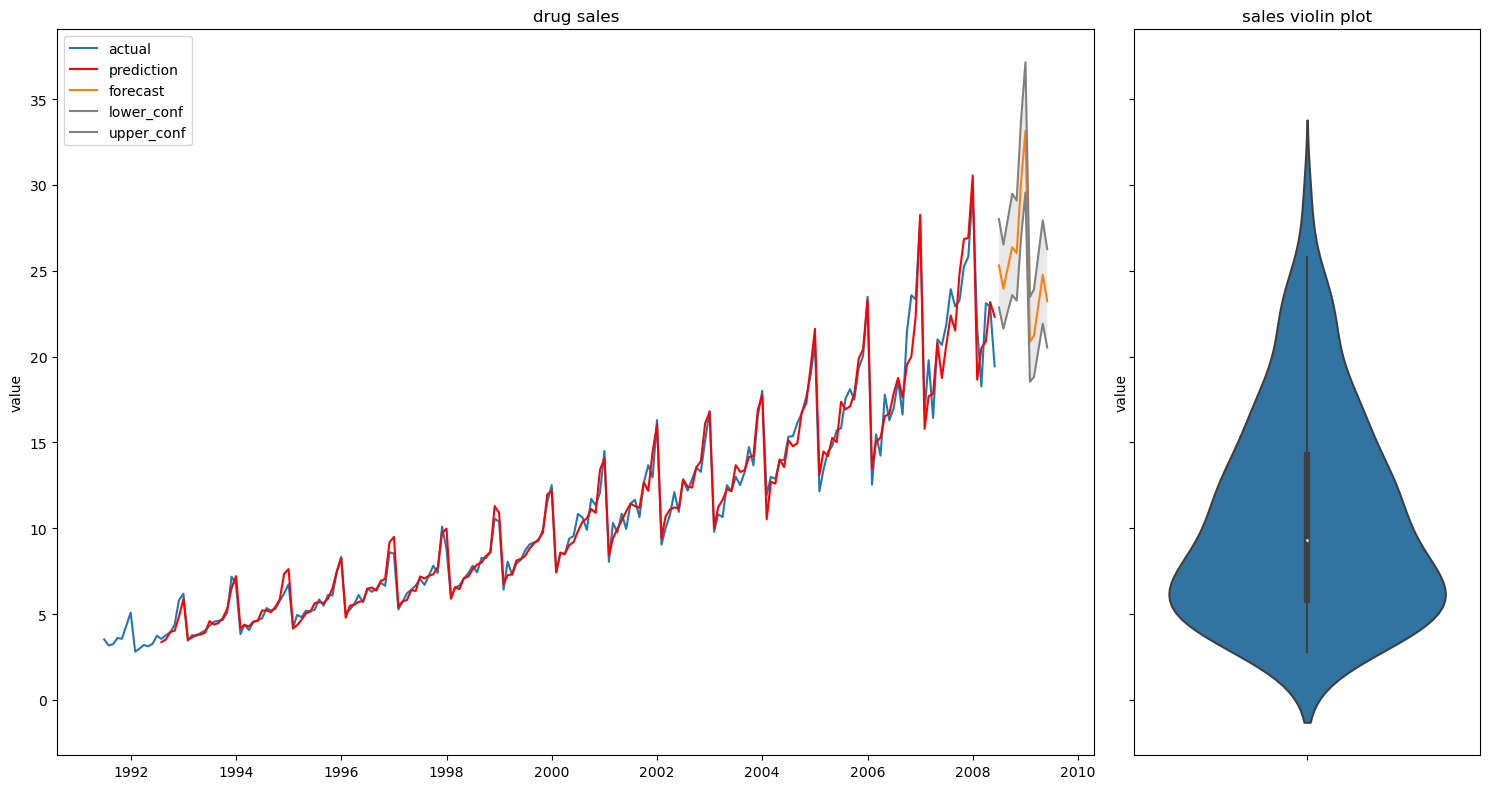

In [169]:
drugs['model'] = inv_boxcox(best_model3.fittedvalues, lmbd)
fig, (ax, a2) = plt.subplots(1, 2,  sharey='row', gridspec_kw={'width_ratios': [3, 1]}, figsize=(15,8), dpi= 100)

ax.plot(drugs.value, label='actual')
ax.plot(drugs.model[13:], color='r', label='prediction')
ax.plot(inv_boxcox(best_model3.get_forecast(12).predicted_mean, lmbd), label='forecast')
ax.plot(inv_boxcox(best_model3.get_forecast(12).conf_int()['lower boxcox'], lmbd), label='lower_conf', color = 'gray')
ax.plot(inv_boxcox(best_model3.get_forecast(12).conf_int()['upper boxcox'], lmbd), label='upper_conf', color = 'gray')
ax.fill_between(best_model3.get_forecast(12).predicted_mean.index, 
                inv_boxcox(best_model3.get_forecast(12).conf_int()['lower boxcox'], lmbd), 
                inv_boxcox(best_model3.get_forecast(12).conf_int()['upper boxcox'], lmbd), facecolor='lightgray', alpha=0.5)
ax.legend()

ax.set_ylabel('value')
ax.set_title('drug sales')
a2 = sns.violinplot(y=drugs.value)
a2.set_title('sales violin plot')

fig.tight_layout()
plt.show()

Наши предсказания улавливают внутригодовую сезонность и по метрикам не плохи, дальнейший подбор вероятно не улучшит значительно модель.

Финальная модель получилась SARIMA (4,1,1)x(1,1,8) с сезонностью 12.